# Emperor Penguin - 2090 access
- Plot EP colony distances on CESM grid
- Needs to load files of EP colony distance and population
- Notebook by Alice DuVivier (NCAR)
- February 2025

In [1]:
import utils
import pandas as pd
import xarray as xr
import numpy as np
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd

## Read in penguin data

### Get accessibility data

In [2]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [3]:
# Read in EP data 
file_in = 'CESM_grid_Emperor_individual_access_future.nc'
ds_ep= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [4]:
# sum over all colonies
total_penguins = ds_ep.total_penguins

In [5]:
# Calculate mean for 2090s only
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = total_penguins.isel(time=total_penguins.time.isin([yy]))

# take mean over those years
data_mean = temp.mean(dim='time')

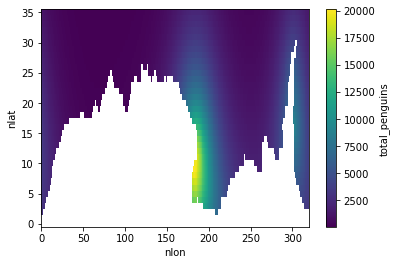

In [6]:
data_mean.plot()

### Read in invdividual Colony location data

In [7]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [8]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Emperor_colony_present_day.nc'
ds_ep = xr.open_dataset(path_in+file_in, decode_times=True)

In [9]:
ds_ep = ds_ep.rename({'index':'colonies'})

In [10]:
# get colony population info for plotting
data_col_lat = ds_ep.colony_lat
data_col_lon = ds_ep.colony_lon

### Read in individual Emperor colony population projections

In [11]:
# these population projections are for years 1900-2100
years = np.arange(1900,2101,1)
tlen = len(years)
print(tlen)

201


In [12]:
# load future Emperor Penguin population projections
file_in = 'Emperor_colony_future_projections_median_CMR.csv'
data = pd.read_csv(path_in + file_in)

In [13]:
data

,SNOW,JASN,DOLL,SMTH,GOUL,LUIT,HALY,DAWS,STCB,DRES,...,BEAR,BSON,NOVI,PFRO,BRYA,SMYL,VERD,ROTS,DION,DARL
0,3787.200,5561.6,9887.4,3424.70,4438.100,5251.900,12448.000,5385.500,6916.2000,7923.7000,...,1508.700,1497.000,1557.900,407.270,1180.700,1668.000,479.910,1530.700,447.630,408.000
1,3473.200,9186.2,9753.3,3467.50,4200.100,6500.900,12984.000,5773.400,7588.0000,7817.9000,...,1379.900,1451.500,1419.400,666.520,1161.300,1543.500,773.160,918.070,461.680,354.010
2,2895.900,10699.0,9572.0,3472.20,3887.200,6823.000,12589.000,5020.600,6852.7000,6297.7000,...,1047.100,1168.400,1032.800,691.330,939.260,1075.800,759.470,691.710,306.550,260.050
3,2452.300,11843.0,9397.9,3515.80,3608.600,7181.900,12239.000,4634.700,6432.3000,5648.4000,...,914.990,989.050,912.080,725.670,869.880,977.200,785.000,617.270,261.330,212.110
4,2126.100,12699.0,9300.9,3506.10,3460.300,7370.400,12045.000,4505.000,6427.2000,5401.2000,...,828.240,939.070,857.410,743.780,864.150,958.630,791.470,617.490,243.000,210.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,36.406,2112.8,5476.0,1177.80,128.570,34.413,27.461,28.782,22.5750,11.8540,...,47.374,46.015,41.024,38.824,38.502,40.874,36.415,34.453,20.301,18.949
197,35.144,2065.3,5369.4,973.65,92.625,30.361,22.423,23.605,17.8470,9.2708,...,42.972,41.904,37.345,34.650,33.760,36.175,32.570,30.722,18.692,15.433
198,36.473,1809.2,5089.8,904.18,71.048,23.696,19.254,19.939,14.1610,7.3993,...,45.310,43.717,38.995,36.778,36.068,38.808,34.855,33.879,21.752,19.057
199,32.297,1753.5,4657.8,797.08,44.398,20.674,15.084,15.647,11.4960,5.6889,...,41.729,40.317,36.196,33.632,33.366,35.553,32.313,31.683,19.353,15.033


In [14]:
# convert future data to xarray
populations = xr.DataArray(data,dims=('year','colonies'))

In [15]:
# assign metadata
populations['year'] = years
populations['colonies'] = ds_ep.colonies

### Calculate population means for 2000s and 2090s to get health status

In [16]:
# choose decade
dec = 2000

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = populations.isel(year=populations.year.isin([yy]))

# take mean over those years
pop_mean_2000s = temp.mean(dim='year')

In [17]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = populations.isel(year=populations.year.isin([yy]))

# take mean over those years
pop_mean_2090s = temp.mean(dim='year')

In [18]:
# calculate percent difference from 2000s to get colony health
pct_diff = 100.0* ((pop_mean_2090s - pop_mean_2000s)/pop_mean_2000s)

### Load grid and mask data

In [19]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [20]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [21]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [22]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

### Load regional mask data and shapefiles

In [23]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [24]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [25]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [26]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [27]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [28]:
# mask to omit land points
data_mean = data_mean.where(ds_grid.REGION_MASK == 1)

### Set plotting ranges, etc.

In [29]:
print(data_mean.max(dim=['nlat','nlon']))

<xarray.DataArray 'total_penguins' ()>
dask.array<nanmax-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


In [30]:
# set some plotting info
cmap_in = cmocean.cm.dense
vmin_in = 0.0
vmax_in = 50000.0
#vmax_in = 20000.0
levels_in_poly = np.arange(0,3,1)
levels_in_ctr = np.arange(0,3,1)
units = '# Emperor Penguins'
title = 'Emperor Penguin access to each grid point'

In [70]:
# set circle colors for colonies
# loop through each colony population and set it based on 4 options (from Stef's previous work)
# 1 --> "healthy", colony population decrease < 30%
# 2 --> "vulnerable", colony_population decrease >= 30% and < 50%
# 3 --> "endangered", colony_population decrease >= 50% and < 90%
# 4 --> "quasi-extinct", colony population decrease >= 90%

clen = len(populations.colonies)
color_list = []

for col in np.arange(0,clen,1):
    value = pct_diff.isel(colonies=col)
    if (value > -30.0):
        color = 'forestgreen'
        #color_list.append = "blue"
    elif ((value > -50.0) and (value <= -30.0)):
        color = 'greenyellow'
        #color_list.append = "lightskyblue"
    elif ((value > -90.0) and (value <= -50.0)):
        color = 'gold'
        #color_list.append = "darkgoldenrod"
    elif (value <= -90.0):
        color = 'darkgoldenrod'
        #color_list.append = "firebrick"
    # add to list
    color_list.append(color)

# Set some lats/lons, etc. for a legend
lons_leg = [0,0,0,0]
lats_leg = [-83.0,-85.0,-87.0,-89.0]
area_leg = [100,100,100,100]
text_leg = ['Healthy','Vulnerable','Endangered','Quasi-extinct']

### Save plot

In [71]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'
fout = 'Figure_3_Emperor_access_2090'

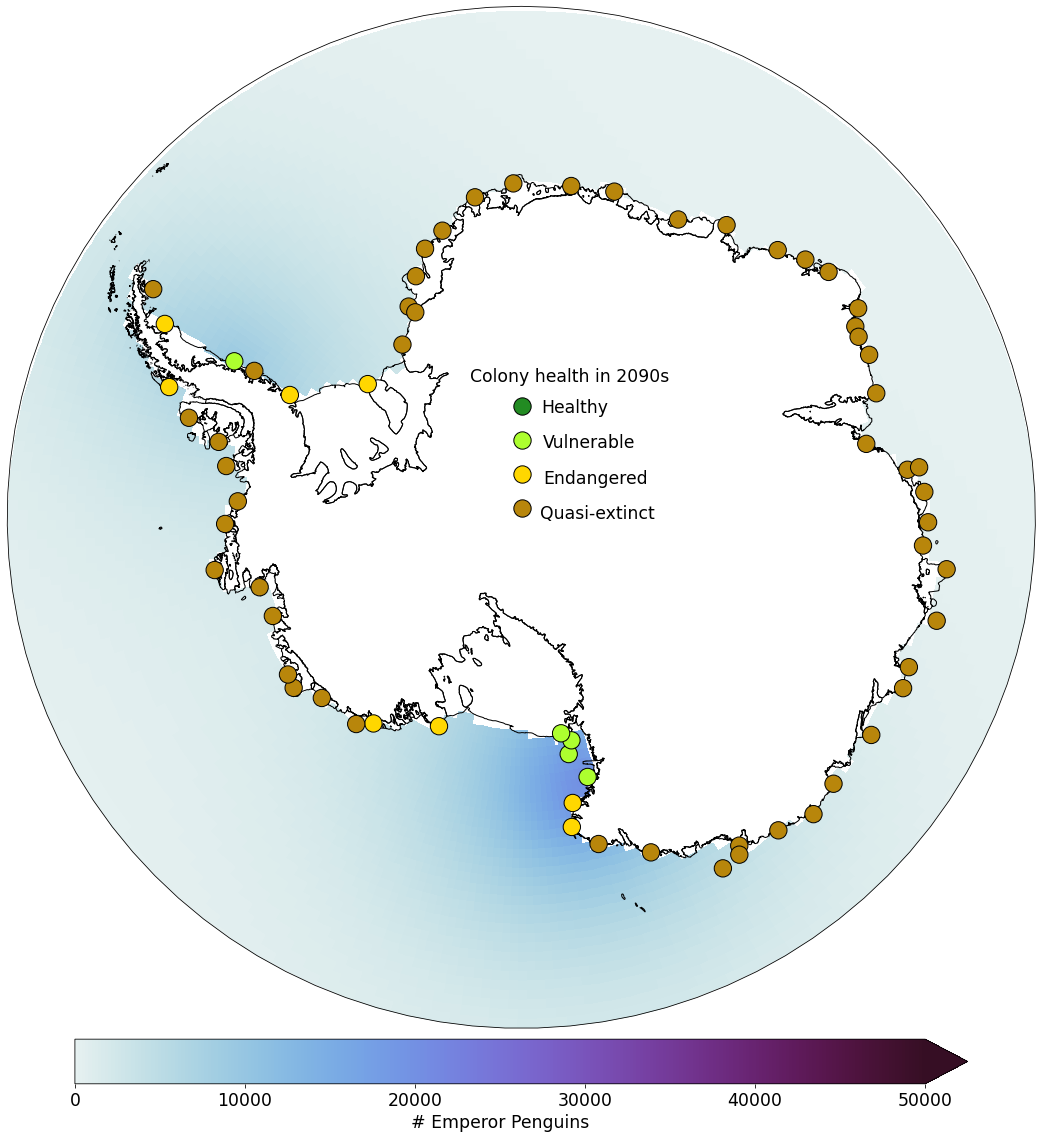

In [72]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('# Emperor Penguins',fontsize='xx-large')

### Plot Colony Locations - sizes vary by colony size
this1=ax.scatter(data_col_lon,data_col_lat,
                 color=color_list, edgecolor='black', s=300,
                 zorder = 100,
                 transform=ccrs.PlateCarree())

### Add legend for colony size
# text for legend
this2=ax.text(-20.0,-81.0,
              'Colony health in 2090s',
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
# first dot
n = 0
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this3=ax.scatter(lon_plt,lat_plt,
                 color='forestgreen', edgecolor='black', s=300,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this3t=ax.text(lon_plt+10,lat_plt-0.25,
              text_plt,
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
# second dot
n = 1
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this4=ax.scatter(lon_plt,lat_plt,
                 color='greenyellow', edgecolor='black', s=300,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this4t=ax.text(lon_plt+15,lat_plt-0.25,
              text_plt,
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
# third dot
n = 2
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this5=ax.scatter(lon_plt,lat_plt,
                 color='gold', edgecolor='black', s=300,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this5t=ax.text(lon_plt+28,lat_plt-0.25,
              text_plt,
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
# fourth dot
n = 3
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this6=ax.scatter(lon_plt,lat_plt,
                 color='darkgoldenrod', edgecolor='black', s=300,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this6t=ax.text(lon_plt+70,lat_plt+0.18,
              text_plt,
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)